# Humans and animals integrate multisensory cues near-optimally
## An intuition for how populations of neurons can perform Bayesian inference

In [30]:
from __future__ import division
import numpy as np
from scipy.special import factorial
import scipy.stats as stats
import pylab
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import ipywidgets
from IPython.display import display
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('medium')
%config InlineBackend.figure_format = 'svg'


def mean_firing_rate(gain, stimulus, preferred_stimulus, std_tc, baseline):
    # Gaussian tuning curve that determines the mean firing rate (Poisson rate parameter) for a given stimulus
    return baseline + gain*stats.norm.pdf(preferred_stimulus, loc = stimulus, scale = std_tc)

def get_spikes(gain, stimulus, preferred_stimuli, std_tc, baseline):
    # produce a vector of spikes for some population given some stimulus
    lambdas = mean_firing_rate(gain, stimulus, preferred_stimuli, std_tc, baseline)
    return np.random.poisson(lambdas)
                
def likelihood(stimulus, r, gain, preferred_stimuli, std_tc, baseline):
    # returns p(r|s)
    lambdas = mean_firing_rate(gain, stimulus, preferred_stimuli, std_tc, baseline)
    return np.prod(lambdas**r)

def spikes_and_inference(r_V = True,
                         r_A = True,
                         show_tuning_curves = False,
                         show_spike_count = False,
                         show_likelihoods = True,
                         true_stimulus = 10,
                         number_of_neurons = 40,
                         r_V_gain = 15,
                         r_A_gain = 75,
                         r_V_tuning_curve_sigma = 10,
                         r_A_tuning_curve_sigma = 10,
                         tuning_curve_baseline = 0,
                         joint_likelihood = True,
                         r_V_plus_r_A = True,
                         cue = False):
    np.random.seed(7)
    max_s = 40
    preferred_stimuli = np.linspace(-max_s*2, max_s*2, number_of_neurons)
    n_hypothesized_s = 250
    hypothesized_s = np.linspace(-max_s, max_s, n_hypothesized_s)
    gains     = {'r1':    r_V_gain,
                 'r2':    r_A_gain,
                 'r1+r2': r_V_gain + r_A_gain}
    sigma_TCs = {'r1':    r_V_tuning_curve_sigma,
                 'r2':    r_A_tuning_curve_sigma,
                 'r1+r2': (r_V_tuning_curve_sigma + r_A_tuning_curve_sigma)/2}
    spikes    = {'r1':    get_spikes(gains['r1'], true_stimulus, preferred_stimuli, sigma_TCs['r1'], tuning_curve_baseline),
                 'r2':    get_spikes(gains['r2'], true_stimulus, preferred_stimuli, sigma_TCs['r2'], tuning_curve_baseline)}
    spikes['r1+r2'] = spikes['r1'] + spikes['r2']
    active_pops = []
    if r_V: active_pops.append('r1')
    if r_A: active_pops.append('r2')
    if r_V_plus_r_A: active_pops.append('r1+r2')

    colors = {'r1':    sns.xkcd_rgb['light purple'],
              'r2':    sns.xkcd_rgb['dark pink'],
              'r1+r2': sns.xkcd_rgb['royal blue'],
              'joint': sns.xkcd_rgb['gold']}
    nSubplots = show_spike_count + show_tuning_curves + show_likelihoods
    fig, axes = plt.subplots(nSubplots, figsize = (7, 1.5*nSubplots)) # number of subplots according to what's been requested
    if not isinstance(axes, np.ndarray): axes = [axes] # makes axes into a list even if it's just one subplot
    subplot_idx = 0
    
    def plot_true_stimulus_and_legend(subplot_idx):
        axes[subplot_idx].plot(true_stimulus, 0, 'k^', markersize = 12, clip_on = False, label = 'true rattlesnake location')
        axes[subplot_idx].legend(loc = 'center left', bbox_to_anchor = (1, 0.5), prop = fontP)
    
    if show_tuning_curves:
        for neuron in range(number_of_neurons):
            if r_V:
                axes[subplot_idx].plot(hypothesized_s,
                                       mean_firing_rate(gains['r1'],
                                                        hypothesized_s,
                                                        preferred_stimuli[neuron],
                                                        sigma_TCs['r1'],
                                                        tuning_curve_baseline),
                                       color = colors['r1'])
            if r_A:
                axes[subplot_idx].plot(hypothesized_s,
                                       mean_firing_rate(gains['r2'],
                                                        hypothesized_s,
                                                        preferred_stimuli[neuron],
                                                        sigma_TCs['r2'],
                                                        tuning_curve_baseline),
                                       color = colors['r2'])
        axes[subplot_idx].set_xlabel('location $s$')
        axes[subplot_idx].set_ylabel('mean firing rate\n(spikes/s)')
        axes[subplot_idx].set_ylim((0, 4))
        axes[subplot_idx].set_xlim((-40, 40))
        axes[subplot_idx].set_yticks(np.linspace(0, 4, 5))
        subplot_idx += 1

    if show_spike_count:
        idx = abs(preferred_stimuli) < max_s
        if r_V:
            axes[subplot_idx].plot(preferred_stimuli[idx], spikes['r1'][idx], 'o', color = colors['r1'],
                                   clip_on = False,  label = '$\mathbf{r}_\mathrm{V}$',
                                   markersize=4)
        if r_A:
            axes[subplot_idx].plot(preferred_stimuli[idx], spikes['r2'][idx], 'o', color = colors['r2'],
                                   clip_on = False, label = '$\mathbf{r}_\mathrm{A}$',
                                   markersize=4)
        if r_V_plus_r_A:
            axes[subplot_idx].plot(preferred_stimuli[idx], spikes['r1+r2'][idx], 'o', color = colors['r1+r2'],
                                   clip_on = False, label = '$\mathbf{r}_\mathrm{V}+\mathbf{r}_\mathrm{A}$',
                                   markersize=8, zorder=1)
        axes[subplot_idx].set_xlabel('preferred location')
        axes[subplot_idx].set_ylabel('spike count')
        axes[subplot_idx].set_ylim((0, 10))
        axes[subplot_idx].set_xlim((-40, 40))
        plot_true_stimulus_and_legend(subplot_idx)
        subplot_idx += 1

    if show_likelihoods:
        if cue:
            var = 'c'
        else:
            var = '\mathbf{r}'
        likelihoods = {}
            
        for population in active_pops:
            likelihoods[population] = np.zeros_like(hypothesized_s)
            for idx, ort in enumerate(hypothesized_s):
                likelihoods[population][idx] = likelihood(ort, spikes[population], gains[population],
                                                          preferred_stimuli, sigma_TCs[population], tuning_curve_baseline)
            likelihoods[population] /= np.sum(likelihoods[population]) # normalize

        if r_V:
            axes[subplot_idx].plot(hypothesized_s, likelihoods['r1'], color = colors['r1'],
                                   linewidth = 2, label = '$p({}_\mathrm{{V}}|s)$'.format(var))
        if r_A:
            axes[subplot_idx].plot(hypothesized_s, likelihoods['r2'], color = colors['r2'],
                                   linewidth = 2, label = '$p({}_\mathrm{{A}}|s)$'.format(var))
        if r_V_plus_r_A:
            axes[subplot_idx].plot(hypothesized_s, likelihoods['r1+r2'], color = colors['r1+r2'],
                                   linewidth = 2, label = '$p({}_\mathrm{{V}}+{}_\mathrm{{A}}|s)$'.format(var, var))
        if joint_likelihood:
            product = likelihoods['r1']*likelihoods['r2']
            product /= np.sum(product)
            axes[subplot_idx].plot(hypothesized_s, product, color = colors['joint'],linewidth = 7,
                                   label = '$p({}_\mathrm{{V}}|s)\ p({}_\mathrm{{A}}|s)$'.format(var, var), zorder = 1)

        axes[subplot_idx].set_xlabel('location $s$')
        axes[subplot_idx].set_ylabel('probability')
        axes[subplot_idx].set_xlim((-40, 40))
        axes[subplot_idx].legend()
        axes[subplot_idx].set_yticks([])
        
        plot_true_stimulus_and_legend(subplot_idx)
        subplot_idx += 1

<p>We live in a complex environment and must constantly integrate sensory information to interact with the world around us. Inputs from different modalities might not always be congruent with each other, but dissociating the true nature of the stimulus may be a matter of life or death for an organism.</p>
<img src="http://www.wtadler.com/picdrop/rattlesnake.jpg" width=25% height=25% align="left" style="margin: 10px 10px 10px 0px;" >
<p>You hear and see evidence of a rattlesnake in tall grass near you. You get an auditory and a visual cue of the snake's location $s$. Both cues are associated with a likelihood function indicating the probability of that cue for all possible locations of the snake. The likelihood function associated with the visual cue, $p(c_\mathrm{V}|s)$, has high uncertainty, because of the tall grass. The auditory cue is easier to localize, so its associated likelihood function, $p(c_\mathrm{A}|s)$, is sharper. In accordance with Bayes' Rule, and assuming a flat prior over the snake's location, an optimal estimate of the location of the snake can be computed by multiplying the two likelihoods. This joint likelihood will be between the two cues but closer to the less uncertain cue, and will have less uncertainty than both unimodal likelihood functions.</p>

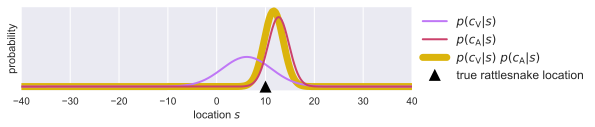

In [31]:
spikes_and_inference(show_likelihoods = True, r_V_plus_r_A = False, cue = True)

Behavioral experiments have demonstrated that humans perform near-optimal Bayesian inference on ambiguous sensory information (van Beers *et al.*, 1999; Ernst & Banks, 2002; Kording & Wolpert, 2004; Stocker & Simoncelli, 2006). This has been demonstrated in cue combination experiments in which subjects report a near-optimal estimate of the stimulus given two noisy measurements of that stimulus. However, the neural basis for how humans might perform these computations is unclear. 

Ma *et. al.* (2006) propose that variance in cortical activity, rather than impairing sensory systems, is an adaptive mechanism to encode uncertainty in sensory measurements. They provide theory showing how the brain might use probabilistic population codes to perform near-optimal cue combination. We will re-derive the theory in here, and demonstrate it by simulating and decoding neural populations.

## Cues can be represented by neural populations

To return to our deadly rattlesnake, let's now assume that $c_\mathrm{V}$ and $c_\mathrm{A}$ are represented by populations of neurons $\mathbf{r}_\mathrm{V}$ and $\mathbf{r}_\mathrm{A}$, respectively. For our math and simulations, we assume that $\mathbf{r}_\mathrm{V}$ and $\mathbf{r}_\mathrm{A}$ are each composed of $N$ neurons that:

* have independent Poisson variability
* have regularly spaced Gaussian tuning curves that are identical in mean and variance for neurons with the same index in both populations

The populations may have different gains, $g_\mathrm{V}$ and $g_\mathrm{A}$.

These are the tuning curves for the neurons in $\mathbf{r}_\mathrm{V}$ (purple) and $\mathbf{r}_\mathrm{A}$ (red). Each curve represents the mean firing rate of a single neuron given a location $s$. Each neuron thus has a preferred location, which is where its tuning curve peaks.

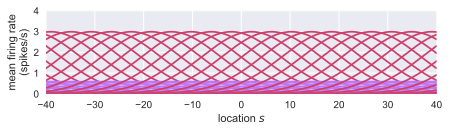

In [32]:
spikes_and_inference(show_tuning_curves = True, show_likelihoods = False)

The tuning curves are dense enough that we can also assume that $\sum_{i=0}^N f_i(s) = k$ (*i.e.*, the sum of the tuning curves in a population is constant.)

First, we will show how the brain can decode a likelihood over stimulus from neural activity. Then we will ask how the brain can compute joint likelihoods.
### How can the brain decode $p(\mathbf{r_\mathrm{V}}|s)$?

\begin{align}
L(s) &= p(\mathbf{r_\mathrm{V}}\ |\ s) \tag{1} \\ 
&= \prod_{i=0}^N \frac{e^{-g_\mathrm{V}\ f_i(s)}\ g_\mathrm{V}\ f_i(s)^{r_{\mathrm{V}i}}}{r_{\mathrm{V}i}!} \tag{2} \\
&\propto \prod_{i=0}^N e^{-g_\mathrm{V}\ f_i(s)}\ f_i(s)^{r_{\mathrm{V}i}} \tag{3} \\
&= e^{-g_\mathrm{V}\sum_{i=0}^N f_i(s)} \prod_{i=0}^N f_i(s)^{r_{\mathrm{V}i}}\tag{4} \\ 
&= e^{-g_\mathrm{V}k} \prod_{i=0}^N f_i(s)^{r_{\mathrm{V}i}} \tag{5} \\
&\propto \prod_{i=0}^N f_i(s)^{r_{\mathrm{V}i}} \tag{6} \\
\end{align}

### Then what is the joint likelihood $p(\mathbf{r_\mathrm{V}}|s)\ p(\mathbf{r_\mathrm{A}}|s)$?

\begin{align}
L(s) &= p(\mathbf{r_\mathrm{V}}\ |\ s)\ p(\mathbf{r_\mathrm{A}}|s) \tag{7} \\
&\propto \prod_{i=0}^N f_i(s)^{r_{\mathrm{V}i}}\ \prod_{i=0}^N f_i(s)^{r_{\mathrm{A}i}} \tag{8} \\
&= \prod_{i=0}^N f_i(s)^{r_{\mathrm{V}i}+r_{\mathrm{A}i}} \tag{9} \\
\end{align}

## How can the brain compute the joint likelihood $p(\mathbf{r}_\mathrm{V}|s)\ p(\mathbf{r}_\mathrm{A}|s)$?
The fact that we see neurons from $\mathbf{r}_\mathrm{V}$ and $\mathbf{r}_\mathrm{A}$ being added on a neuron-by-neuron basis in the exponent above suggests that we could construct a third population vector, $\mathbf{r}_\mathrm{V}+\mathbf{r}_\mathrm{A}$, and decode that.

### First, we must prove that the sum of two Poisson-distributed random variables $X+Y$ is again Poisson-distributed.
\begin{align}
X &\sim \textrm{Poisson}(\lambda_x) \textrm{, so } p(X=k)=\frac{\lambda_x^k\ e^{-\lambda_x}}{k!} \tag{10} \\
Y &\sim \textrm{Poisson}(\lambda_y) \textrm{, so } p(X=k)=\frac{\lambda_y^k\ e^{-\lambda_y}}{k!} \tag{11} \\
X+Y &\overset{?}{\sim} \textrm{Poisson}(\lambda_{x+y}) \textrm{ and, if so, } \lambda_{x+y}=? \tag{12} \\
\end{align}

\begin{align}
p(X+Y=n) &= p(X=0)\ p(Y=n) + p(X=1)\ p(Y=n-1)\ +...+\ p(X=n-1)\ p(Y = 1) + p(X=n)\ p(Y=0) \tag{13} \\
&= \sum_{k=0}^n p(X=k)\ p(Y=n-k) \tag{14} \\
&= \sum_{k=0}^n \frac{\lambda_x^k\ e^{-\lambda_x}\ \lambda_y^{n-k}\ e^{-\lambda_y}}{k!(n-k)!} \tag{15} \\
&= e^{-(\lambda_x+\lambda_y)} \sum_{k=0}^n \frac{1}{k!(n-k)!}\ \lambda_x^k\ \lambda_y^{n-k} \tag{16} \\
&= e^{-(\lambda_x+\lambda_y)} \frac{1}{n!} \sum_{k=0}^n \frac{n!}{k!(n-k)!}\ \lambda_x^k\ \lambda_y^{n-k} \tag{17} \\
&= e^{-(\lambda_x+\lambda_y)} \frac{1}{n!} \sum_{k=0}^n \binom{n}{k}\ \lambda_x^k\ \lambda_y^{n-k}\ [ \textrm{because} \frac{n!}{k!(n-k)!}=\binom{n}{k} ]\tag{18} \\
&=\frac{e^{-(\lambda_x + \lambda_y)}(\lambda_x+\lambda_y)^n}{n!} [ \textrm{because} \sum_{k=0}^n \binom{n}{k}\ x^ky^{n-k} = (x+y)^n ]\tag{19} \\
\end{align}

Therefore, $X + Y \sim \mathrm{Poisson}(\lambda_x + \lambda_y)$.

## What is $p(\mathbf{r}_\mathrm{V}+\mathbf{r}_\mathrm{A} | s)$?

In our case:

\begin{align}
r_{\mathrm{V}i} &\sim \textrm{Poisson}(g_\mathrm{V}\ f_i(s)) \tag{20} \\
r_{\mathrm{A}i} &\sim \textrm{Poisson}(g_\mathrm{A}\ f_i(s)) \tag{21} \\
r_{\mathrm{V}i}+r_{\mathrm{A}i} &\sim \textrm{Poisson}((g_\mathrm{V}+g_\mathrm{A})\ f_i(s)) \tag{22} \\
\end{align}

\begin{align}
L(s)&=p(\mathbf{r}_\mathrm{V} + \mathbf{r}_\mathrm{A}\ |\ s)
= \prod_{i=0}^N \frac{e^{-f_i(s)(g_\mathrm{V}+g_\mathrm{A})}\ (g_\mathrm{V}+g_\mathrm{A})\ f_i(s)^{r_{\mathrm{V}i}+r_{\mathrm{A}i}}}{(r_{\mathrm{V}i}+r_{\mathrm{A}i})!} \tag{23} \\
&\propto \prod_{i=0}^N e^{-f_i(s)(g_\mathrm{V}+g_\mathrm{A})}\ f_i(s)^{r_{\mathrm{V}i}+r_{\mathrm{A}i}} \tag{24} \\
&= e^{-(g_\mathrm{V}+g_\mathrm{A})\sum_{i=0}^Nf_i(s)} \prod_{i=0}^N \ f_i(s)^{r_{\mathrm{V}i}+r_{\mathrm{A}i}} \tag{25} \\
&= e^{-(g_\mathrm{V}+g_\mathrm{A})k} \prod_{i=0}^N \ f_i(s)^{r_{\mathrm{V}i}+r_{\mathrm{A}i}} \tag{26} \\
&\propto \prod_{i=0}^N f_i(s)^{r_{\mathrm{V}i}+r_{\mathrm{A}i}} \tag{27} \\
\end{align}

Since equations $(9)$ and $(27)$ are proportional, we have shown that optimal cue combination can be executed by decoding linear sums of populations.

$$x = 2$$

## Simulation
Here are the spike counts (during 1 s) from the two populations on one trial. Depicted in blue is a third population vector that is the sum of $\mathbf{r}_\mathrm{V}$ and $\mathbf{r}_\mathrm{A}$.

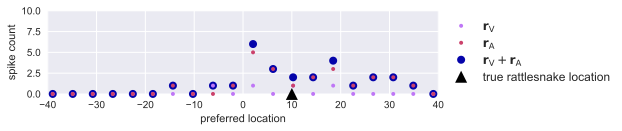

In [33]:
spikes_and_inference(show_spike_count = True, show_likelihoods = False)

Here are the decoded likelihoods for each population alone $(6)$, the joint likelihood $(9)$, and the likelihood for the summed population $(27)$. Note that the joint likelihood (gold) is less uncertain than either unimodal likelihood. Also note that it is identical to the likelihood for the summed population (blue).

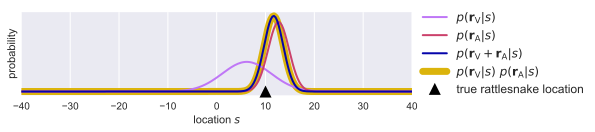

In [34]:
spikes_and_inference()

Here, we break the assumption that the two populations have the same tuning curve width. Note that the joint likelihood (gold) is no longer identical to the likelihood for the summed population (blue).

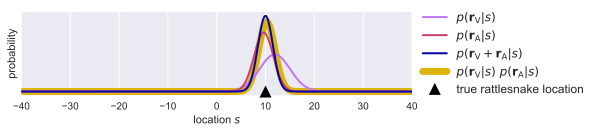

In [35]:
spikes_and_inference(r_V_tuning_curve_sigma = 7, r_A_tuning_curve_sigma = 10)

Now you can play interactively with the parameters of the simulation using these sliders, and watch the decoded likelihoods shift around. Every time you change a parameter, new sets of spikes are generated and used to infer $s$.

For the simulation to be interactive, you'll have to download this notebook.

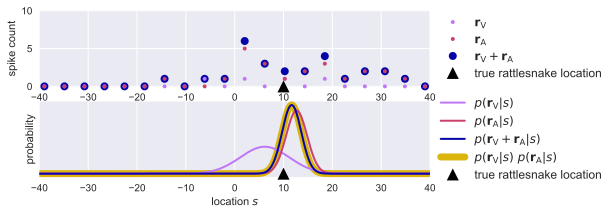

In [36]:
i = ipywidgets.interactive(spikes_and_inference,
              true_stimulus = (-40, 40, .1),
              number_of_neurons = (2, 200, 1),
              r_V_gain = (0, 100, 1),
              r_A_gain = (0, 100, 1),
              r_V_tuning_curve_sigma = (0.1, 50, .1),
              r_A_tuning_curve_sigma = (0.1, 50, .1),
              tuning_curve_baseline = (0, 20, .1));
display(ipywidgets.VBox(i.children[2:-1]))

## Conclusion

It has been shown behaviorally that humans perform near-optimal Bayesian inference on ambiguous sensory information. As suggested by Ma *et. al.* (2006) and shown here, it is possible that the brain does this operation by simply performing linear combinations of populations of Poisson neurons receiving various sensory input. Cortical neurons may be particularly well suited for this task because they have Poisson-like firing rates, displaying reliable variability from trial to trial (Tolhurst, Movshon & Dean, 1982; Softky & Koch, 1993).

High levels of noise in these populations might at first be difficult to reconcile considering highly precise behavioral data. However, variability in neural populations might be direcly representative of uncertainty in environmental stimuli. Variability in cortical populations would then be critical for precise neural coding.

## References

* Ernst MO, Banks MS. (2002). Humans integrate visual and haptic information in a statistically optimal fashion. *Nature.*
* Körding KP, Wolpert DM. (2004). Bayesian integration in sensorimotor learning. *Nature.*
* Ma WJ, Beck JM, Latham PE, Pouget A. (2006). Bayesian inference with probabilistic population codes. *Nature Neuroscience.*
* Softky WR, Koch C. (1993). The highly irregular firing of cortical cells is inconsistent with temporal integration of random EPSPs. *Journal of Neuroscience.*
* Stocker AA, Simoncelli EP. (2006). Noise characteristics and prior expectations in human visual speed perception. *Nature Neuroscience.*
* Tolhurst, DJ, Movshon JA, Dean AF. (1983). The statistical reliability of signals in single neurons in cat and monkey visual cortex. *Vision Research.*
* van Beers RJ, Sittig AC, Gon JJ. (1999). Integration of proprioceptive and visual position-information: An experimentally supported model. *Journal of Neurophysiology.*